In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import warnings
import torch
import random
from IPython import display
from matplotlib import pyplot as plt
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn
warnings.filterwarnings("ignore")

In [ ]:
# 定义dataset
class my_Dataset(data.Dataset):
  def __init__(self, features, labels):
    self.X = features
    self.y = labels

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.X.shape[0]

In [ ]:
class TrafficDataset:
  def __init__(self, sensor=10, target=0):
    # 选取适当的检测器用作序列数据
    self.raw_data = np.load('/content/traffic.npz')['data']
    self.sensor = sensor
    self.target = target
    # 数据标准化
    self.min = self.raw_data.min()
    self.max = self.raw_data.max()
    self.data = (self.raw_data - self.min) / (self.max - self.min)

  def denormalize(self, x):
    return x * (self.max - self.min) + self.min

  def construct_set(self, train_por = 0.6, test_por = 0.2, window_size = 12, label=0):
    # 预测车流量 选取1号传感器，滑动窗口大小设置为12
    train_x = []
    train_y = []
    val_x = []
    val_y = []
    test_x = []
    test_y = []
    sensor_num = 1

    # 补全构造过程
    #训练集
    len_train = int(self.data.shape[0] * train_por)
    train_seqs = self.data[:len_train]
    for i in range(train_seqs.shape[0] - window_size):
      train_x.append(train_seqs[i:i + window_size, sensor_num, :].squeeze())
      train_y.append(train_seqs[i + window_size, sensor_num, label].squeeze())

    # train_x = torch.Tensor(train_x)
    # train_y = torch.Tensor(train_y)
    #验证集
    len_val = int(self.data.shape[0] * (train_por+test_por))
    val_seqs = self.data[len_train:len_val]
    for i in range(val_seqs.shape[0] - window_size):
      val_x.append(val_seqs[i:i + window_size, sensor_num, :].squeeze())
      val_y.append(val_seqs[i + window_size, sensor_num, label].squeeze())

    # val_x = torch.Tensor(val_x)
    # val_y = torch.Tensor(val_y)
    #测试集
    test_seqs = self.data[len_val:]
    for i in range(test_seqs.shape[0] - window_size):
      test_x.append(test_seqs[i:i + window_size, sensor_num, :].squeeze())
      test_y.append(test_seqs[i + window_size, sensor_num, label].squeeze())

    # test_x = torch.Tensor(test_x)
    # test_y = torch.Tensor(test_y)

    train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
    val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
    test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
    return train_set, val_set, test_set

In [ ]:
def mape_fn(y, pred):
  mask = y != 0
  y = y[mask]
  pred = pred[mask]
  mape = np.abs((y - pred) / y)
  mape = np.mean(mape) * 100
  return mape


def eval(y, pred):
  y = y.cpu().numpy()
  pred = pred.cpu().numpy()
  mse = mse_fn(y, pred)
  rmse = math.sqrt(mse)
  mae = mae_fn(y, pred)
  mape = mape_fn(y, pred)
  return [rmse, mae, mape]


In [ ]:
def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
  x = np.arange(0, num_epochs + 1).astype(dtype=np.int)
  plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1.5)
  plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1.5)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend()
  plt.show()


def plot_metric(score_log):
  score_log = np.array(score_log)

  plt.figure(figsize=(10, 6), dpi=300)
  plt.subplot(2, 2, 1)
  plt.plot(score_log[:, 0], c='#d28ad4')
  plt.ylabel('RMSE')

  plt.subplot(2, 2, 2)
  plt.plot(score_log[:, 1], c='#e765eb')
  plt.ylabel('MAE')

  plt.subplot(2, 2, 3)
  plt.plot(score_log[:, 2], c='#6b016d')
  plt.ylabel('MAPE')

  plt.show()


In [ ]:
TrafficData = TrafficDataset()
train_set, val_set, test_set = TrafficData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

In [ ]:
class My_LSTM(nn. Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn. Tanh()
    self.output = nn.Sequential(
      nn.Linear(hidden_size, hidden_size // 2),
      nn.ReLU(),
      nn.Linear(hidden_size // 2, output_size)
    )
    for param in self.parameters():
      if param.dim() > 1:
        nn.init.xavier_uniform_(param)

  def forward(self, x):
    batch_size = x.size(0)
    seq_len = x.size(1)
    h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
    y_list = []
    for i in range(seq_len):
      forget_gate, input_gate, output_gate, candidate_cell = \
          self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
      forget_gate, input_gate, output_gate = (self.sigmoid(g) for g in (forget_gate, input_gate, output_gate))
      c = forget_gate * c + input_gate * self.tanh(candidate_cell)
      h = output_gate * self.tanh(c)
      y_list.append(self.output(h))
    return torch.stack(y_list, dim=1), (h, c)

In [ ]:
def mape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  non_zero_index = (y_true > 0)
  y_true = y_true[non_zero_index]
  y_pred = y_pred[non_zero_index]

  mape = np.abs((y_true - y_pred) / y_true)
  mape[np.isinf(mape)] = 0
  return np.mean(mape) * 100

In [ ]:
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
  rmse, mae, mape = 0, 0, 0
  batch_count = 0
  total_loss = 0.0
  net.eval()
  if output_model is not None:
    output_model.eval()
  for X, Y in data_iter:
    X = X.to(device).float()
    Y = Y.to(device).float()
    output, hidden = net(X)
    if output_model is not None:
      y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
    else:
      y_hat = output[:, -1, :].squeeze(-1)
    loss = loss_fn(y_hat, Y)

    Y = denormalize_fn(Y)
    y_hat = denormalize_fn(y_hat)
    a, b, c = eval(Y.detach(), y_hat.detach())
    rmse += a
    mae += b
    mape += c
    total_loss += loss.detach().cpu().numpy().tolist()
    batch_count += 1
  return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count

In [ ]:
def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
  train_loss_lst = []
  val_loss_lst = []
  train_score_lst = []
  val_score_lst = []
  epoch_time = []

  best_epoch = 0
  best_val_rmse = 9999
  early_stop_flag = 0
  for epoch in range(num_epoch):
    net.train()
    if output_model is not None:
      output_model.train()
    epoch_loss = 0
    batch_count = 0
    batch_time = []
    rmse, mae, mape = 0, 0, 0
    for X, Y in train_iter:
      batch_s = time.time()
      X = X.to(device).float()
      Y = Y.to(device).float()
      optimizer.zero_grad()
      output, hidden = net(X)
      if output_model is not None:
        y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
      else:
        y_hat = output[:, -1, :].squeeze(-1)
      # print('---------------------------------------------')
      # print(y_hat,Y)
      # print('--------------------------------------------')
      loss = loss_fn(y_hat, Y)
      loss.backward()
      optimizer.step()

      Y = denormalize_fn(Y)
      y_hat = denormalize_fn(y_hat)
      a, b, c = eval(Y.detach(), y_hat.detach())
      rmse += a
      mae += b
      mape += c
      epoch_loss += loss.detach().cpu().numpy().tolist()
      batch_count += 1
      # sample_num += X.shape[0]

      batch_time.append(time.time() - batch_s)
      if is_print and is_print_batch:
        print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %(epoch + 1, batch_count, epoch_loss, batch_time[-1]))

    train_loss = epoch_loss / batch_count
    train_loss_lst.append(train_loss)
    train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

    # 验证集
    val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
    val_score_lst.append(val_score)
    val_loss_lst.append(val_loss)

    epoch_time.append(np.array(batch_time).sum())

    # 打印本轮训练结果
    if is_print:
      print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
          (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

    # 早停
    if val_score[0] < best_val_rmse:
      best_val_rmse = val_score[0]
      best_epoch = epoch
      early_stop_flag = 0
    else:
      early_stop_flag += 1
      if early_stop_flag == early_stop:
        print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
        break

  # 输出最终训练结果
  print(f'\n{"*" * 40}\nFinal result:')
  print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
  print(f'Total time {np.array(epoch_time).sum():.2f}s')
  print()

  # 计算测试集效果
  test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
  print('Test result:')
  print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
  return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
print(input_size)
hidden_size = 32
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 50
loss_func = nn.MSELoss()

my_rnn = My_LSTM(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

3


In [ ]:
train_loss_lst, val_loss_lst,train_score_lst, val_score_lst, stop_epoch = [], [], [], [], 0
train_loss_lst, val_loss_lst,train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                          loss_func, TrafficData.denormalize, optimizer, epochs,
                                          early_stop=50, device=device, output_model=None)

*** epoch1, train loss 0.5138, train rmse 818.2635, val loss 0.3659, val rmse 680.477227, time use 1.687s
*** epoch2, train loss 0.2651, train rmse 588.2491, val loss 0.1942, val rmse 490.058496, time use 1.638s
*** epoch3, train loss 0.0853, train rmse 310.2639, val loss 0.0129, val rmse 124.828397, time use 1.645s
*** epoch4, train loss 0.0121, train rmse 125.9411, val loss 0.0116, val rmse 117.311621, time use 1.641s
*** epoch5, train loss 0.0107, train rmse 118.4174, val loss 0.0101, val rmse 108.925226, time use 1.641s
*** epoch6, train loss 0.0092, train rmse 109.6644, val loss 0.0085, val rmse 101.475918, time use 1.666s
*** epoch7, train loss 0.0076, train rmse 99.4156, val loss 0.0068, val rmse 91.045686, time use 1.639s
*** epoch8, train loss 0.0059, train rmse 87.7133, val loss 0.0052, val rmse 78.803558, time use 1.656s
*** epoch9, train loss 0.0043, train rmse 75.2330, val loss 0.0037, val rmse 66.723165, time use 1.673s
*** epoch10, train loss 0.0031, train rmse 63.2988, 

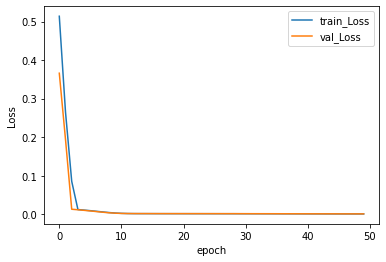

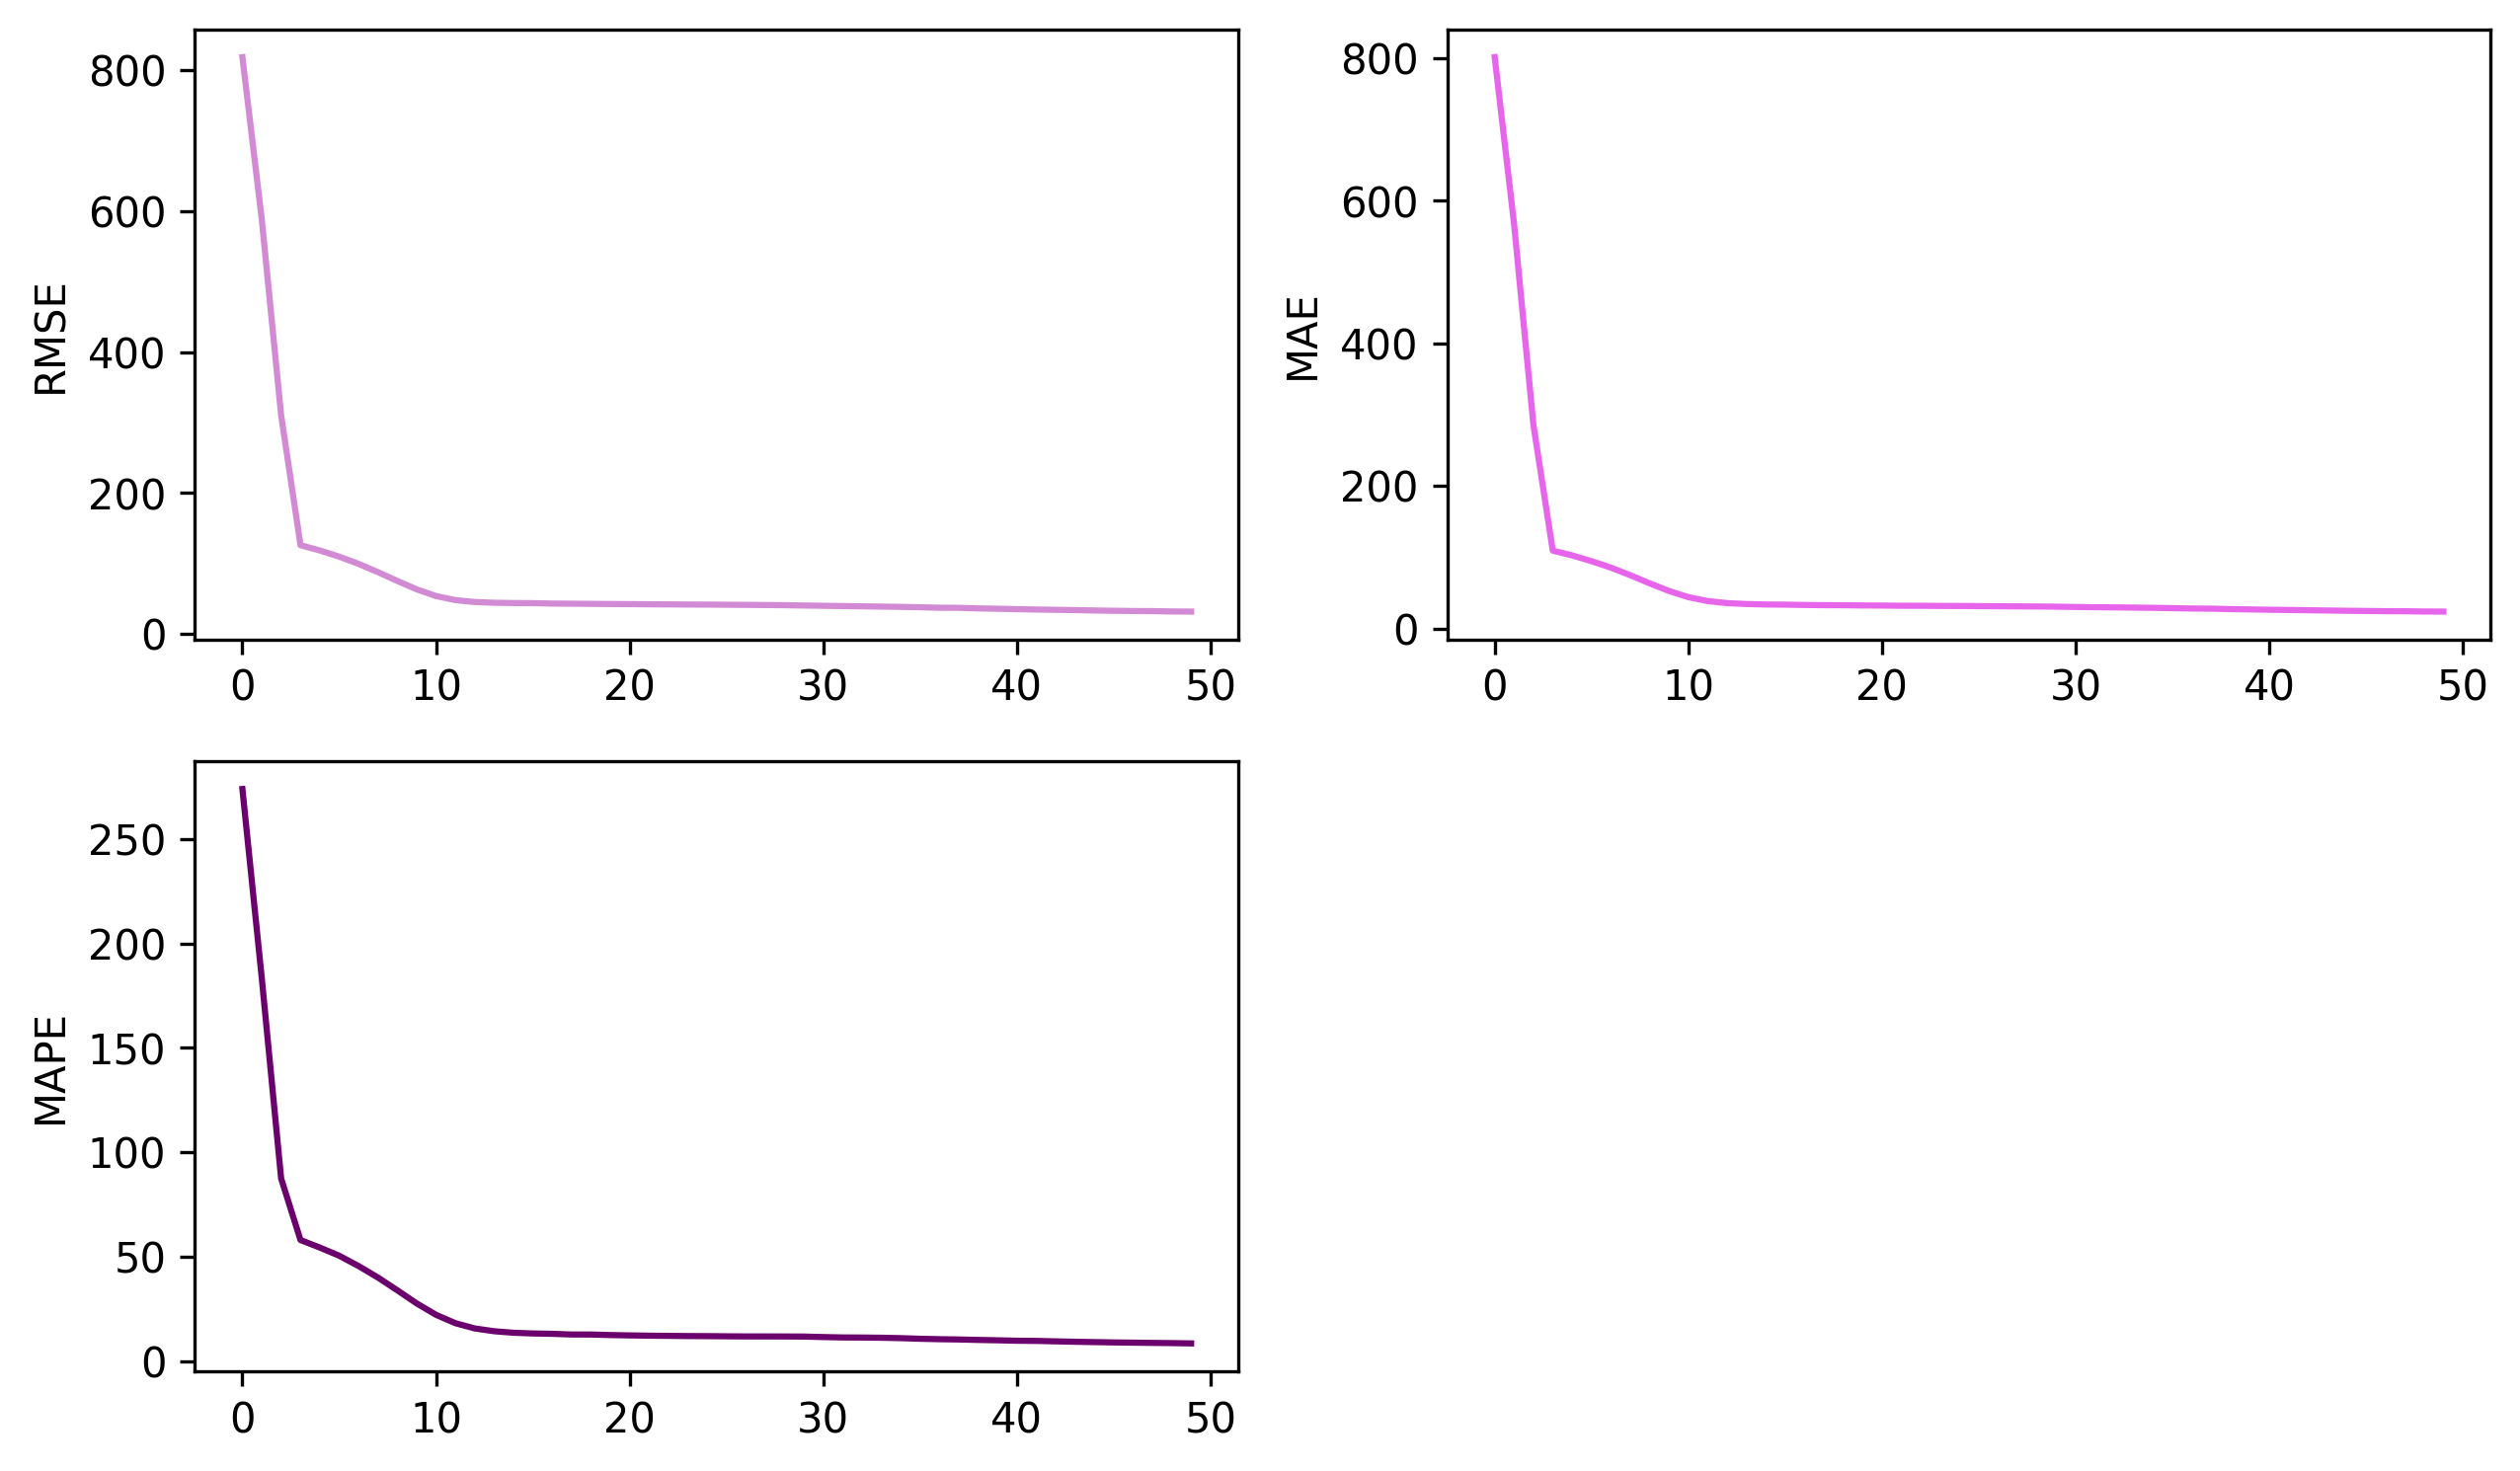

In [ ]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 32
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 50
loss_func = nn.MSELoss()

nn_rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                              loss_func, TrafficData.denormalize, optimizer, epochs,
                              early_stop=50, device=device, output_model=out_linear)

*** epoch1, train loss 0.0354, train rmse 211.1381, val loss 0.0165, val rmse 144.971035, time use 1.370s
*** epoch2, train loss 0.0124, train rmse 127.3651, val loss 0.0111, val rmse 113.816964, time use 0.416s
*** epoch3, train loss 0.0096, train rmse 112.2142, val loss 0.0081, val rmse 96.818448, time use 0.407s
*** epoch4, train loss 0.0057, train rmse 86.0784, val loss 0.0034, val rmse 61.916957, time use 0.417s
*** epoch5, train loss 0.0020, train rmse 50.5589, val loss 0.0016, val rmse 43.933504, time use 0.410s
*** epoch6, train loss 0.0014, train rmse 42.9405, val loss 0.0016, val rmse 42.986475, time use 0.410s
*** epoch7, train loss 0.0014, train rmse 42.1507, val loss 0.0015, val rmse 42.382571, time use 0.409s
*** epoch8, train loss 0.0013, train rmse 41.5230, val loss 0.0015, val rmse 41.745748, time use 0.411s
*** epoch9, train loss 0.0013, train rmse 40.7800, val loss 0.0014, val rmse 41.332751, time use 0.422s
*** epoch10, train loss 0.0013, train rmse 40.1506, val los

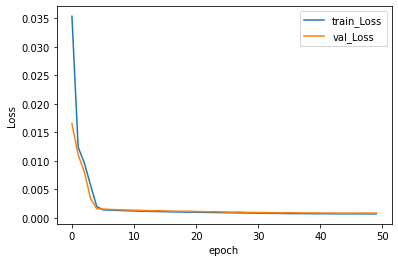

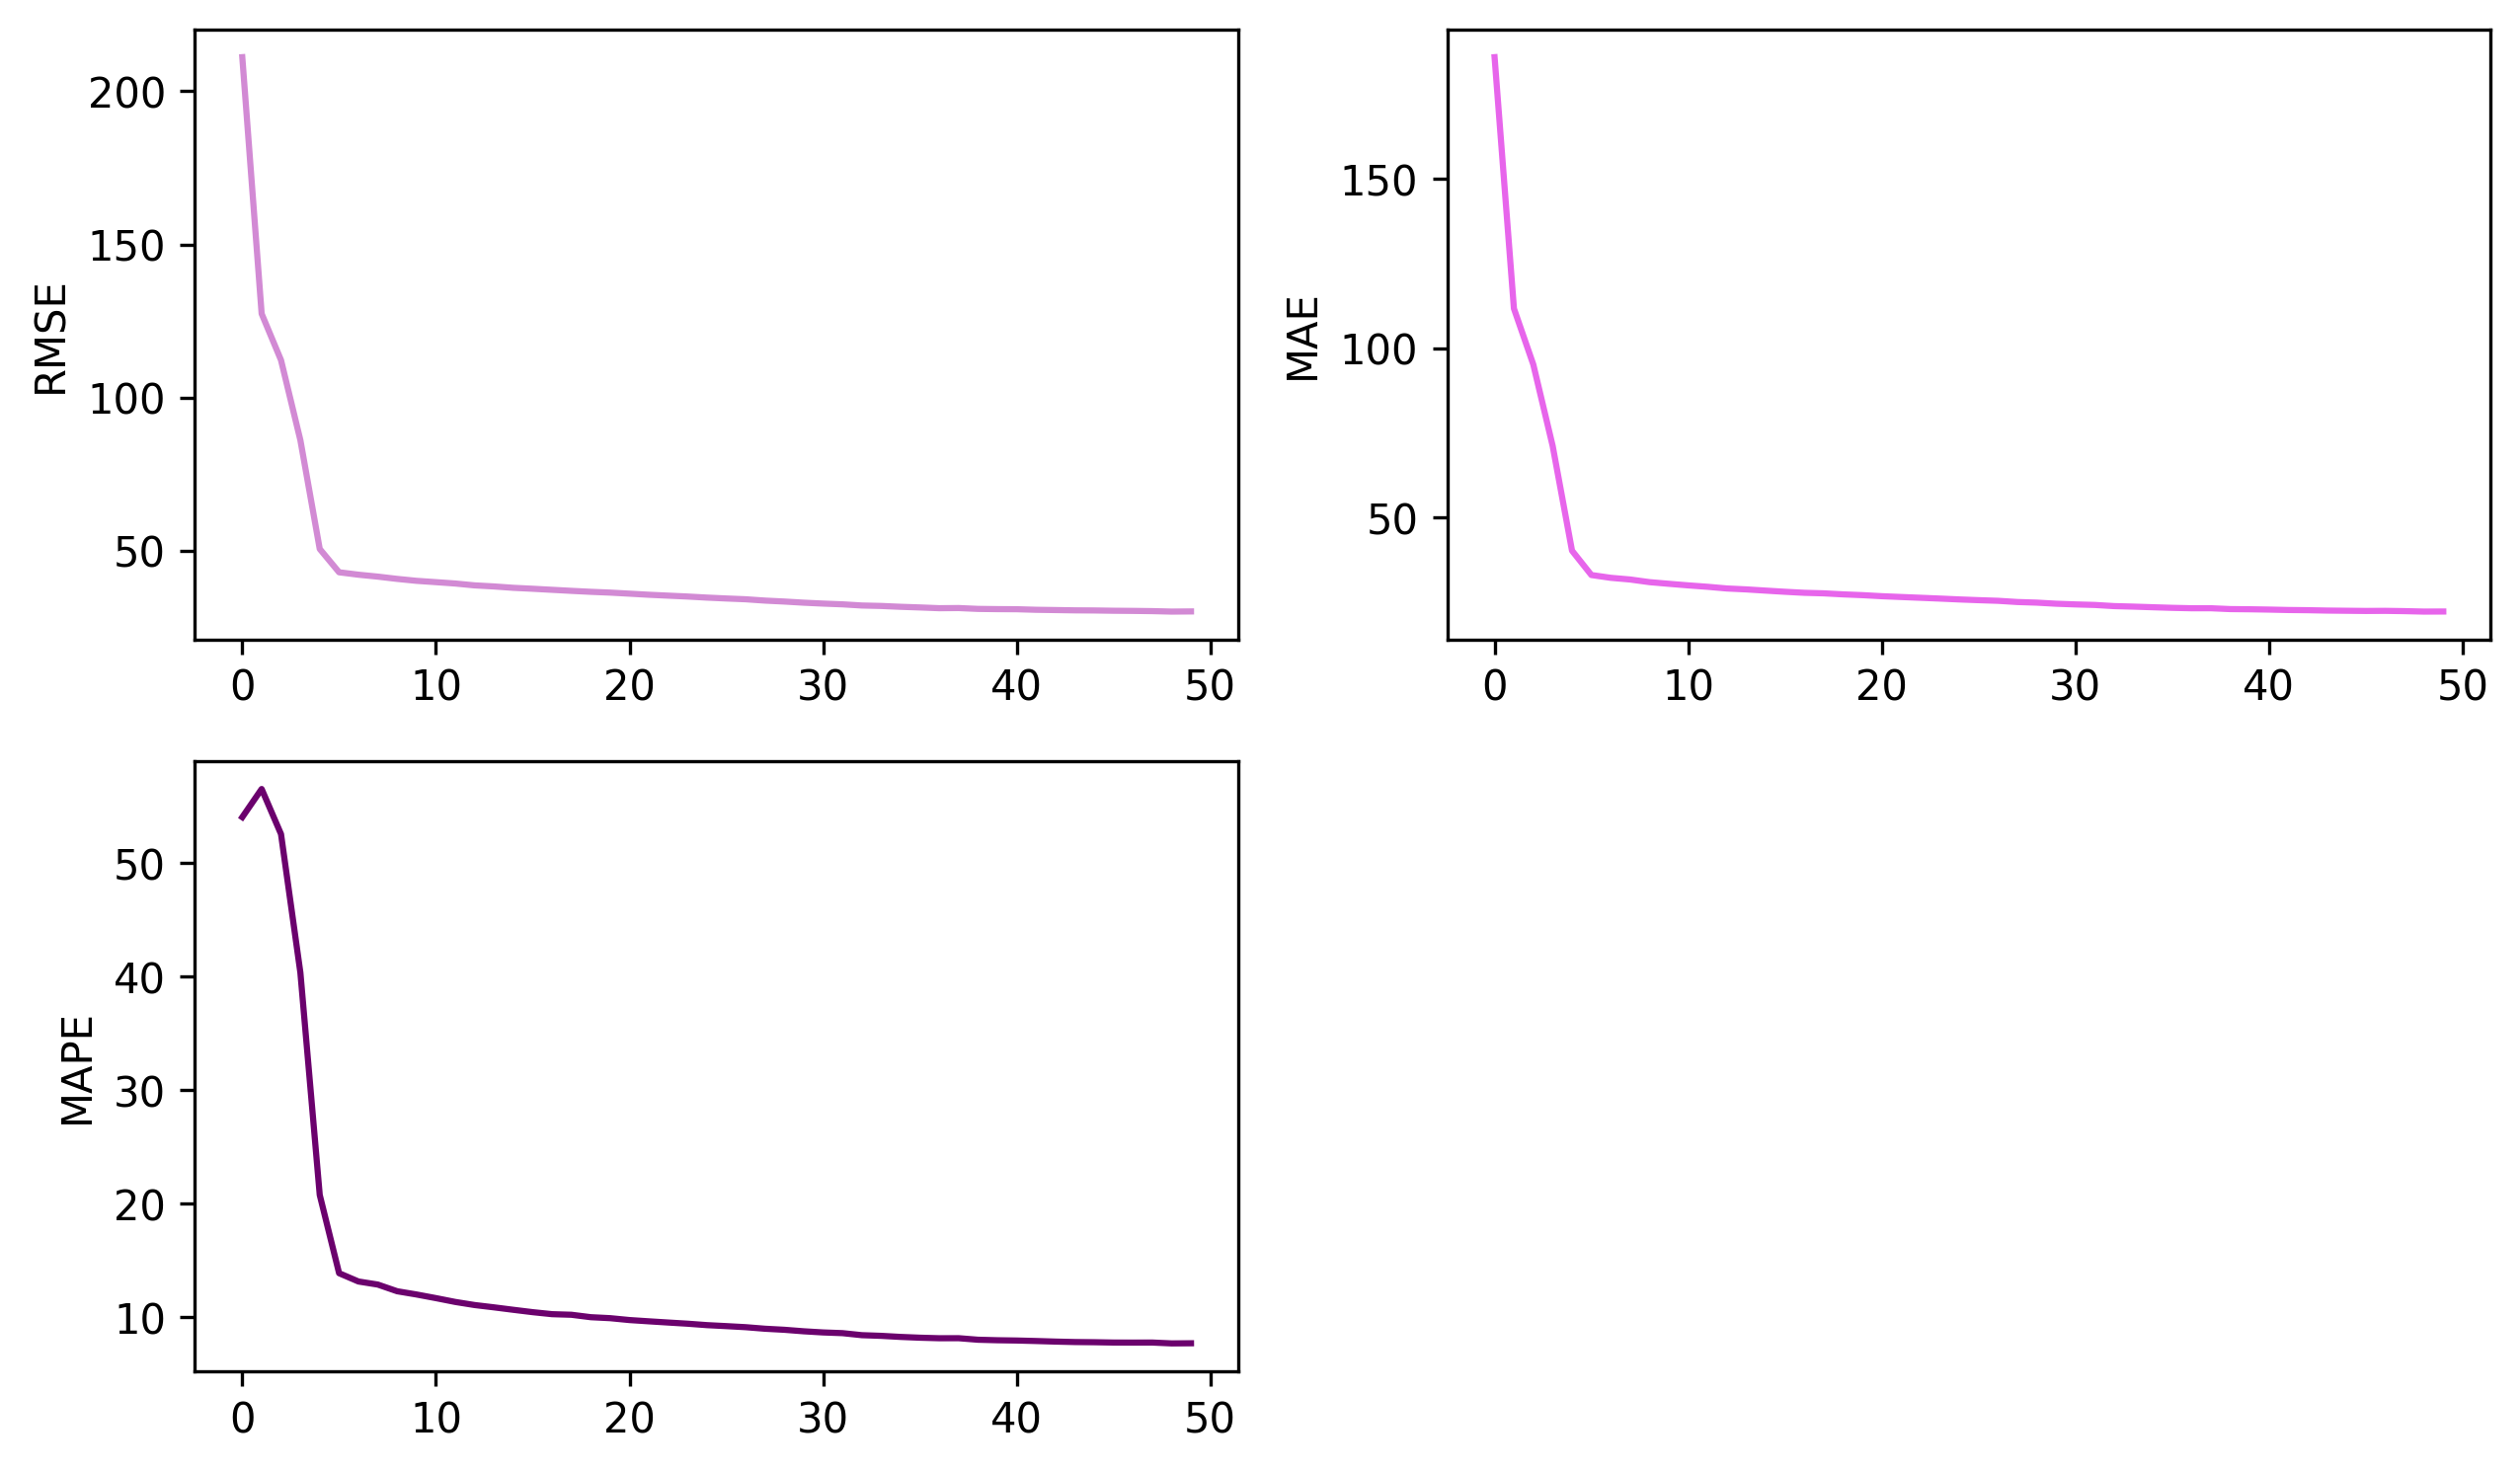

In [ ]:
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)